## Movies Recomendation System with Movie Tweetings Data
### Overview
In this project we will build a **Knowledge Based Recommendation System** to recommend movies to our users using the MovieTweetings 
Dataset.

We will be doing the following steps to implement this project:
- We'll collect the two datasets required, the Movies data and the Reviews data
- We'll do a preliminary descriptive analysis to understand our data.
- we'll the clean our data by handling missing values and extracting relevant features.
- We'll build a function to create a Knowledge based Recommendation System, which would return top ranked items as 
  recommendations with specified filters.

This project has been done as a part of the Udacity Data Scientist Nanodegree program.

In [1]:
# import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from scipy.sparse import csr_matrix
from IPython.display import HTML

In [2]:
# Read in the MovieTweetings dataset originally taken from https://github.com/sidooms/MovieTweetings/tree/master/latest
movies = pd.read_csv('movies.csv', delimiter='::', header=None, names=['movie_id', 'movie', 'genre'], dtype={'movie_id': object}, engine='python')
reviews = pd.read_csv('ratings.csv', delimiter='::', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'], dtype={'movie_id': object, 'user_id': object, 'timestamp': object}, engine='python')

In [3]:
movies.head()

,movie_id,movie,genre
0,0000008,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,0000010,La sortie des usines LumiÃ¨re (1895),Documentary|Short
2,0000012,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,0000091,Le manoir du diable (1896),Short|Horror


In [4]:
# about the movies dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35479 entries, 0 to 35478
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  35479 non-null  object
 1   movie     35479 non-null  object
 2   genre     35230 non-null  object
dtypes: object(3)
memory usage: 831.7+ KB


In [5]:
movies.describe()

,movie_id,movie,genre
count,35479,35479,35230
unique,35479,35416,2736
top,4671274,Home (2016),Drama
freq,1,4,3602


In [6]:
reviews.head()

,user_id,movie_id,rating,timestamp
0,1,0114508,8,1381006850
1,2,0208092,5,1586466072
2,2,0358273,9,1579057827
3,2,10039344,5,1578603053
4,2,6751668,9,1578955697


In [7]:
# about the reviews dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863866 entries, 0 to 863865
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    863866 non-null  object
 1   movie_id   863866 non-null  object
 2   rating     863866 non-null  int64 
 3   timestamp  863866 non-null  object
dtypes: int64(1), object(3)
memory usage: 26.4+ MB


In [8]:
reviews.describe()

,rating
count,863866.000000
mean,7.315878
std,1.853831
min,0.000000
25%,6.000000
50%,8.000000
75%,9.000000
max,10.000000


### Data Cleaning

In [7]:
# In the movies data, pull the date column from the title and create a new column
# extract the release year of the movie 
date = []
for i in movies['movie']:
    date.append(i[-5:-1])
    
movies['year'] = date
movies['year'].head()

0    1894
1    1895
2    1896
3    1895
4    1896
Name: year, dtype: object

In [8]:
# create a column to indicate the century the movie came out in
century = []
for i in movies['year']:
    if i[1] == '8':
        century.append("1800's")
    elif i[1] == '9':
        century.append("1900's")
    elif i[0] == '2':
        century.append("2000's") 
        
movies['century'] = century
movies['century'].head()

0    1800's
1    1800's
2    1800's
3    1800's
4    1800's
Name: century, dtype: object

In [9]:
# add dummy coulmns for the feature century
d_cent = pd.get_dummies(movies['century'])
movies = pd.concat([movies, d_cent], axis=1, join='outer')

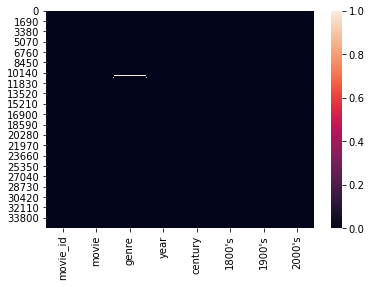

In [10]:
# check for missing values
sns.heatmap(movies.isnull())

In [11]:
# number of missing values in the genre column
movies['genre'].isnull().sum()

249

In [12]:
# drop the null values of the dataframe, only column genre has 249 null values
movies.dropna(axis=0, inplace=True)

### Dummy column genre with 1's and 0's

In [13]:
# split the genre column
genre = []
for i in movies['genre']:
    genre.extend(i.split('|'))
    
genre

['Documentary',
 'Short',
 'Documentary',
 'Short',
 'Documentary',
 'Short',
 'Short',
 'Horror',
 'Short',
 'Comedy',
 'Horror',
 'Short',
 'Action',
 'Adventure',
 'Comedy',
 'Fantasy',
 'Sci-Fi',
 'Short',
 'Action',
 'Crime',
 'Western',
 'Action',
 'Short',
 'Short',
 'Drama',
 'Short',
 'Horror',
 'Sci-Fi',
 'Short',
 'Drama',
 'Romance',
 'Drama',
 'History',
 'Adventure',
 'Drama',
 'Fantasy',
 'Horror',
 'Short',
 'Comedy',
 'Romance',
 'Crime',
 'Drama',
 'Adventure',
 'Drama',
 'History',
 'Comedy',
 'Short',
 'Family',
 'Fantasy',
 'Adventure',
 'Comedy',
 'Short',
 'Comedy',
 'Short',
 'Comedy',
 'Short',
 'Comedy',
 'Short',
 'Comedy',
 'Short',
 'Comedy',
 'Drama',
 'Adventure',
 'Family',
 'Fantasy',
 'Comedy',
 'Short',
 'Comedy',
 'Short',
 'Comedy',
 'Short',
 'Drama',
 'History',
 'War',
 'Short',
 'Comedy',
 'Sport',
 'Drama',
 'Short',
 'Comedy',
 'Biography',
 'Crime',
 'Drama',
 'Romance',
 'Short',
 'Comedy',
 'Action',
 'Adventure',
 'Crime',
 'Drama',
 'Myst

In [14]:
# genres of the movies in the dataset
genre = set(genre)
print(genre)
print('There are {} genres'.format(len(genre)))

{'Music', 'Thriller', 'Drama', 'Musical', 'Fantasy', 'Family', 'Biography', 'Talk-Show', 'Reality-TV', 'Action', 'History', 'War', 'Adult', 'Horror', 'Sci-Fi', 'News', 'Game-Show', 'Comedy', 'Western', 'Romance', 'Adventure', 'Short', 'Crime', 'Sport', 'Animation', 'Film-Noir', 'Documentary', 'Mystery'}
There are 28 genres


In [15]:
# function to create genre columns
def genre_col(x):
    if x.find(gen) > -1:
        return 1
    else:
        return 0

# apply the function to all genres
for gen in genre:
    movies[gen] = movies['genre'].apply(genre_col)

In [16]:
movies.head()

,movie_id,movie,genre,year,century,1800's,1900's,2000's,Music,Thriller,...,Western,Romance,Adventure,Short,Crime,Sport,Animation,Film-Noir,Documentary,Mystery
0,0000008,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1800's,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0000010,La sortie des usines LumiÃ¨re (1895),Documentary|Short,1895,1800's,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0000012,The Arrival of a Train (1896),Documentary|Short,1896,1800's,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0000091,Le manoir du diable (1896),Short|Horror,1896,1800's,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0000131,Une nuit terrible (1896),Short|Comedy|Horror,1896,1800's,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
# Create date out of timestamp in the reviews data
change_timestamp = lambda val: datetime.datetime.fromtimestamp(int(val)).strftime('%Y-%m-%d %H:%M:%S')
reviews['date'] = reviews['timestamp'].apply(change_timestamp)

In [18]:
reviews.head()

,user_id,movie_id,rating,timestamp,date
0,1,0114508,8,1381006850,2013-10-05 17:00:50
1,2,0208092,5,1586466072,2020-04-09 17:01:12
2,2,0358273,9,1579057827,2020-01-14 22:10:27
3,2,10039344,5,1578603053,2020-01-09 15:50:53
4,2,6751668,9,1578955697,2020-01-13 17:48:17


## Knowledge based Recommendations
The goal is to create a list of recommendations based on the most popular movies

In [19]:
def create_ranked_df(movies, reviews):
        '''
        INPUT
        movies - the movies dataframe
        reviews - the reviews dataframe
        
        OUTPUT
        ranked_movies - a dataframe with movies that are sorted by highest avg rating, more reviews, 
                        then time, and must have more than 4 ratings
        '''
        
        # Pull the average ratings and number of ratings for each movie
        movie_ratings = reviews.groupby('movie_id')['rating']
        avg_ratings = movie_ratings.mean()
        num_ratings = movie_ratings.count()
        last_rating = pd.DataFrame(reviews.groupby('movie_id').max()['date'])
        last_rating.columns = ['last_rating']

        # Add Dates
        rating_count_df = pd.DataFrame({'avg_rating': avg_ratings, 'num_ratings': num_ratings})
        rating_count_df = rating_count_df.join(last_rating)

        # merge with the movies dataset
        movie_recs = movies.set_index('movie_id').join(rating_count_df)

        # sort by top avg rating and number of ratings
        ranked_movies = movie_recs.sort_values(['avg_rating', 'num_ratings', 'last_rating'], ascending=False)

        # for edge cases - subset the movie list to those with only 5 or more reviews
        ranked_movies = ranked_movies[ranked_movies['num_ratings'] > 4]
        
        return ranked_movies
    

def popular_recommendations(user_id, n_top, ranked_movies):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_movies - a pandas dataframe of the already ranked movies based on avg rating, count, and time

    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''

    top_movies = list(ranked_movies['movie'][:n_top])

    return top_movies

In [20]:
# most popular movies based on ratings
ranked_movies = create_ranked_df(movies, reviews)

In [21]:
# Top 10 movies recommended for id 2
top_10 = popular_recommendations(2, 10, ranked_movies)
top_10

['MSG 2 the Messenger (2015)',
 'Avengers: Age of Ultron Parody (2015)',
 'Five Minutes (2017)',
 'Selam (2013)',
 'Let There Be Light (2017)',
 "Quiet Riot: Well Now You're Here, There's No Way Back (2014)",
 'Crawl Bitch Crawl (2012)',
 'Chasing Happiness (2019)',
 'Make Like a Dog (2015)',
 'Pandorica (2016)']

In [22]:
# Top 5 movies recommended for id 53968
top_5 = popular_recommendations(53968, 5, ranked_movies)
top_5

['MSG 2 the Messenger (2015)',
 'Avengers: Age of Ultron Parody (2015)',
 'Five Minutes (2017)',
 'Selam (2013)',
 'Let There Be Light (2017)']

In [23]:
ranked_movies

,movie,genre,year,century,1800's,1900's,2000's,Music,Thriller,Drama,...,Short,Crime,Sport,Animation,Film-Noir,Documentary,Mystery,avg_rating,num_ratings,last_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
4921860,MSG 2 the Messenger (2015),Comedy|Drama|Fantasy|Horror,2015,2000's,0,0,1,0,0,1,...,0,0,0,0,0,0,0,10.000000,48,2016-08-14 13:16:50
5262972,Avengers: Age of Ultron Parody (2015),Short|Comedy,2015,2000's,0,0,1,0,0,0,...,1,0,0,0,0,0,0,10.000000,28,2016-01-07 19:44:43
6662050,Five Minutes (2017),Short|Comedy,2017,2000's,0,0,1,0,0,0,...,1,0,0,0,0,0,0,10.000000,22,2019-04-20 18:29:19
2737018,Selam (2013),Drama|Romance,2013,2000's,0,0,1,0,0,1,...,0,0,0,0,0,0,0,10.000000,10,2015-05-10 18:56:01
5804314,Let There Be Light (2017),Drama,2017,2000's,0,0,1,0,0,1,...,0,0,0,0,0,0,0,10.000000,7,2019-12-25 11:27:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10367276,The Rat (2019),Short|Drama,2019,2000's,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1.736842,95,2020-03-23 15:20:07
3108604,American Poltergeist (2015),Horror|Thriller,2015,2000's,0,0,1,0,1,0,...,0,0,0,0,0,0,0,1.666667,6,2018-10-14 13:47:29
3187378,The Asian Connection (2016),Action|Crime|Drama|Thriller,2016,2000's,0,0,1,0,1,1,...,0,1,0,0,0,0,0,1.666667,6,2017-07-11 02:13:16


In [24]:
# adding filters to recommend by year and genre
def popular_recs_filtered(user_id, n_top, ranked_movies, years=None, genres=None):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_movies - a pandas dataframe of the already ranked movies based on avg rating, count, and time
    years - a list of strings with years of movies
    genres - a list of strings with genres of movies
    
    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''
    # Filter movies based on year and genre
    if years is not None:
        ranked_movies = ranked_movies[ranked_movies['year'].isin(years)]

    if genres is not None:
        num_genre_match = ranked_movies[genres].sum(axis=1)
        ranked_movies = ranked_movies.loc[num_genre_match > 0, :]
            
            
    # create top movies list 
    top_movies = list(ranked_movies['movie'][:n_top])

    return top_movies

In [25]:
# Top 10 movies recommended for id 1 with years=['2015', '2016'], genres=['History']
recs_10_for_1_filtered = popular_recs_filtered('1', 10, ranked_movies, years=['2015', '2016'], genres=['History'])
recs_10_for_1_filtered

["Hillary's America: The Secret History of the Democratic Party (2016)",
 'I Believe in Miracles (2015)',
 'O.J.: Made in America (2016)',
 'Hacksaw Ridge (2016)',
 'Kono sekai no katasumi ni (2016)',
 'Sado (2015)',
 'Silicon Cowboys (2016)',
 '13th (2016)',
 'Ethel &amp; Ernest (2016)',
 'Straight Outta Compton (2015)']

### Conclusion

- Thus we built a **Knowledge Based Recommendation System** to return the top ranked items as recommendations to our users, this type of recommendation system is best suited for providing recommendation to new users of a platform.

- This type of system provides generalised recommendations and is not that efficient as preferences changes with every user, for that we can use **Collaborative filtering methods** which involves **Model Based Collaborative filtering** and **Neighborhood Based Collaborative filtering** methods.